In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413
sys.path.append(os.path.abspath('..'))

In [3]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

import makassar_ml as ml

In [4]:
sns.set() # Use seaborn themes.

In [5]:
DATASET_ROOT = Path('~/research/makassar/datasets').expanduser()
if not DATASET_ROOT.exists(): raise ValueError(f"Dataset root directory does not exist at {DATASET_ROOT}")
PROJECT_ROOT = Path('~/research/makassar').expanduser()
CHECKPOINT_ROOT = PROJECT_ROOT / 'checkpoints'
IMAGE_ROOT = PROJECT_ROOT / 'images'
TABLE_ROOT = PROJECT_ROOT / 'tables'
HP_TUNING_ROOT = PROJECT_ROOT / 'hp_tuning'
KERAS_TUNER_PATH = PROJECT_ROOT / 'keras_tuner'

# Ensure some directories exist.
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
IMAGE_ROOT.mkdir(parents=True, exist_ok=True)
TABLE_ROOT.mkdir(parents=True, exist_ok=True)
HP_TUNING_ROOT.mkdir(parents=True, exist_ok=True)
KERAS_TUNER_PATH.mkdir(parents=True, exist_ok=True)

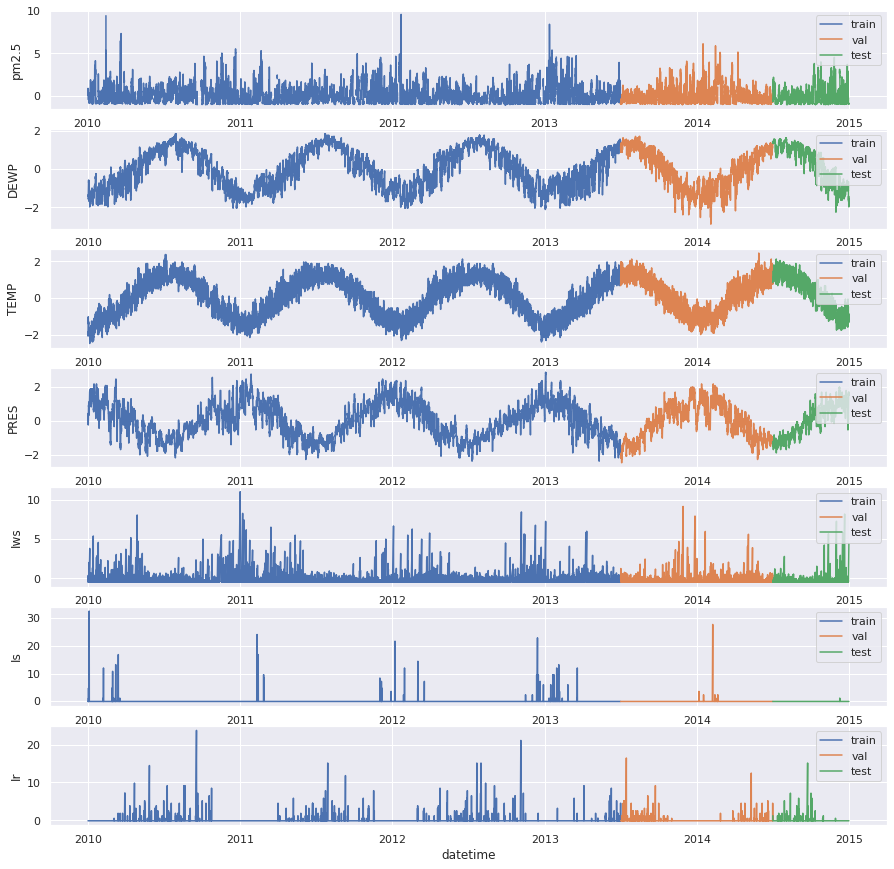

In [7]:
# Load the dataset.
train_df, val_df, test_df = ml.datasets.beijingpm25.load_beijingpm25_df(
    split=(0.7,0.2,0.1),
    path=DATASET_ROOT/'beijing_pm25',
)

# Data keys.
keys = [
    'pm2.5',
    'DEWP',
    'TEMP',
    'PRES',
    'Iws',
    'Is',
    'Ir',
]

# Normalize specific keys.
train_mean = train_df[keys].mean()
train_std = train_df[keys].std()
train_df[keys] = (train_df[keys] - train_mean)/train_std
val_df[keys] = (val_df[keys] - train_mean)/train_std
test_df[keys] = (test_df[keys] - train_mean)/train_std

# Plot features for each partition.
fig = ml.visualization.plot_feature_partitions(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    features=keys,
    x_key='datetime',
    figsize=(15,15),
)
fig.show()

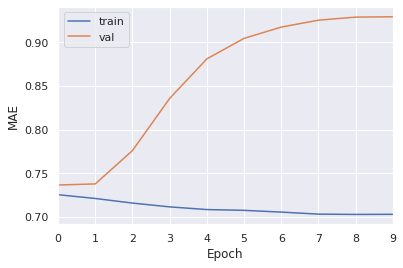

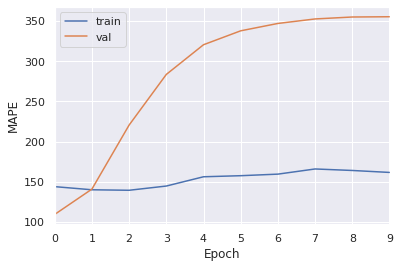

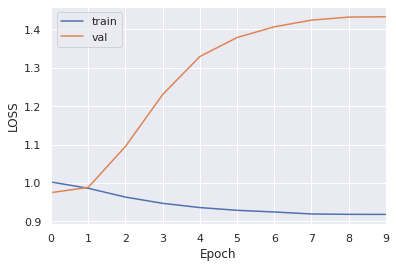

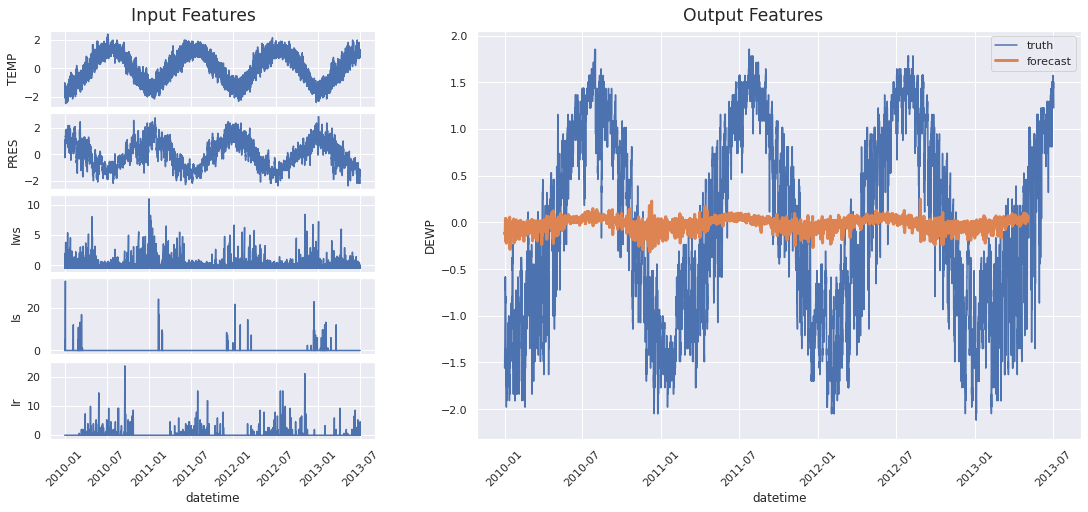

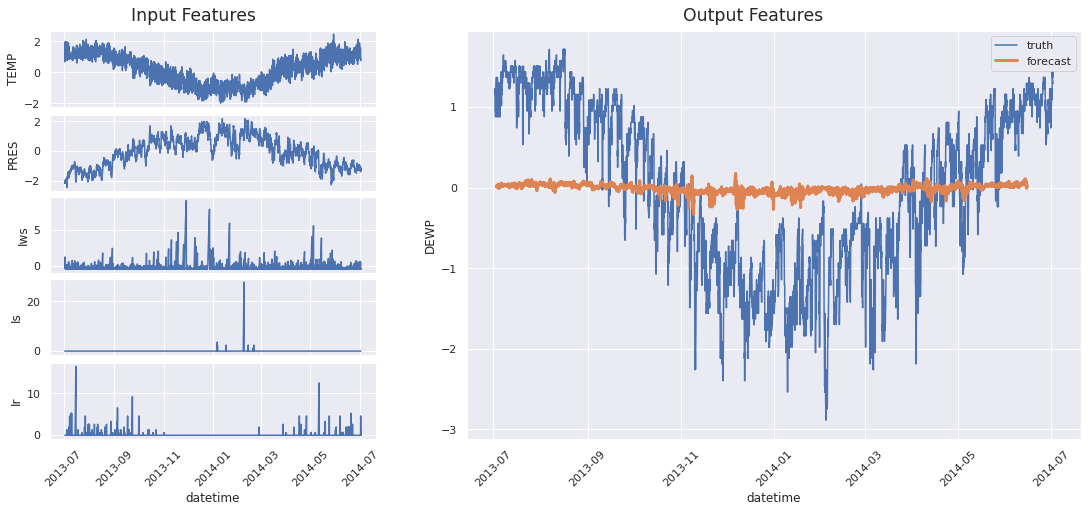

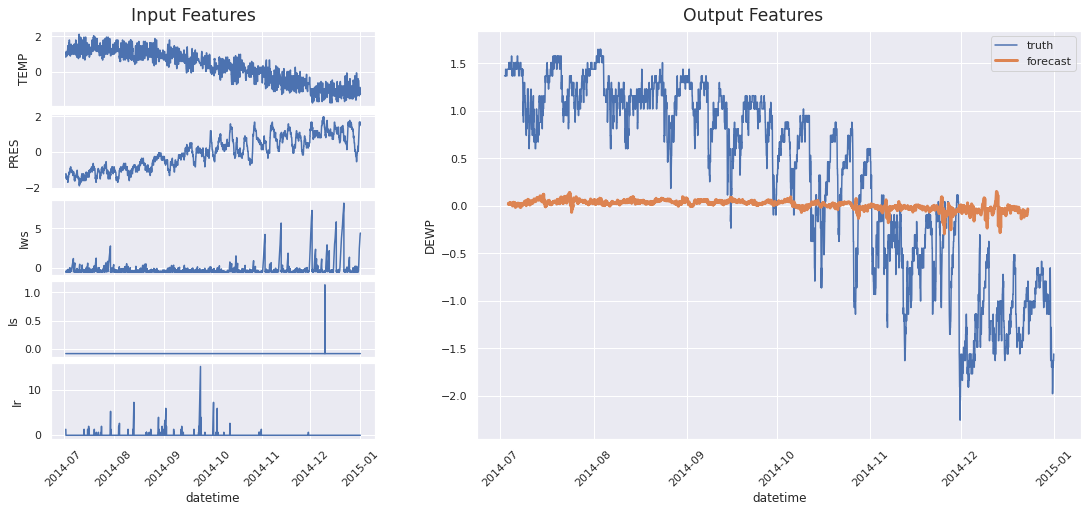

In [15]:
# Define data and training parameters.
epochs = 10
in_seq_len = 30
out_seq_len = 1
shift = 1
split = (0.7,0.2,0.1)
# in_feat = ['year','month','day','hour','pm2.5','DEWP','TEMP','PRES','Iws','Is','Ir']
# in_feat = ['year','month','day','hour','DEWP']
# in_feat = ['DEWP']
in_feat = ['TEMP','PRES','Iws','Is','Ir']
out_feat = ['DEWP']
batch_size = 128
shuffle = False
strategy = tf.distribute.get_strategy()

# Load the dataset to determine total number of training batches.
dataset_train, _, _ = ml.datasets.beijingpm25.load_beijingpm25_ds(
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=shift,
    in_feat=in_feat,
    out_feat=out_feat,
    split=split,
    shuffle=shuffle,
    path=DATASET_ROOT/'beijing_pm25',
    batch_size=batch_size,
)
batches = tf.data.experimental.cardinality(dataset_train).numpy()
del dataset_train # Free memory.



# Create learning rate schedule.
n_steps = epochs*batches
lr_schedule = ml.schedules.LinearWarmupLearningRateScheduleWrapper(
    keras.experimental.CosineDecay
    )(
    warmup_learning_rate=0.0,
    warmup_steps=500,
    initial_learning_rate=1e-5,
    decay_steps=n_steps,
)

# Define model compilation parameters.
# (i.e., loss, metrics, etc.)
compile_params = dict(
    loss='mse',
    metrics=['mae', 'mape'],
)

def build_model_func() -> keras.Model:
    # Model hyperparameters.
    hparams = dict(
        in_seq_len=in_seq_len,
        in_feat=len(in_feat),
        out_feat=len(out_feat),
        fc_units=[64,64],
        embed_dim=4,
        n_heads=8,
        ff_dim=2048,
        dropout=0.1,
        n_encoders=3,
    )

    # Build model.
    model = ml.models.build_transformer_encoder_net(**hparams)

    # Configure optimizer.
    optim = keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model.
    model.compile(optimizer=optim, loss=compile_params['loss'], metrics=compile_params['metrics'])
    return model

def dataset_loader_func(batch_size: int) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    return ml.datasets.beijingpm25.load_beijingpm25_ds(
        in_seq_len=in_seq_len,
        out_seq_len=out_seq_len,
        shift=shift,
        in_feat=in_feat,
        out_feat=out_feat,
        split=split,
        shuffle=shuffle,
        path=DATASET_ROOT/'beijing_pm25',
        batch_size=batch_size,
    )

# optim='adam',
# lr=lr_schedule,

# # Build the resulting table header.
# table_header = ['model']
# for m in ['loss']+compile_params['metrics']:
#     table_header.append(f"{m}")
#     table_header.append(f"val_{m}")
#     table_header.append(f"test_{m}")
# table_header.extend(list(hparams))

# # Create model building function.
# build_model_func = build_model_from_hparams(build_transformer_encoder_net)

# Train and evaluate the model.
# model, hist, met, params, df = train_evaluate_for_dataset(
model, hist, met = ml.training.train_evaluate_for_dataset(
    model_name='transformer',
    build_model_func=build_model_func,
    dataset_loader_func=dataset_loader_func,
    metric_list=compile_params['metrics'],
    # params=hparams,
    # compile_params=compile_params,
    # in_seq_len=in_seq_len,
    # out_seq_len=out_seq_len,
    # shift=shift,
    # split=split,
    # in_feat=in_feat,
    # out_feat=out_feat,
    batch_size=batch_size,
    # shuffle=shuffle,
    strategy=strategy,
    epochs=epochs,
    # table_header=table_header,
    # table_omit_cols=['optim', 'dropout', 'embed_dim', 'mape', 'val_mape', 'test_mape'],
    checkpoint_root=CHECKPOINT_ROOT,
)

# ml.visualization.plot_metric()

# Plot train/val performance.
for key in compile_params['metrics']+['loss']:
    fig = ml.visualization.plot_metric(hist, key)
    # fig.savefig(image_root/f"{model_name}_{key}.png", bbox_inches='tight')
    fig.show()


# Load the data in dataframe form.
df_train, df_val, df_test = ml.datasets.beijingpm25.load_beijingpm25_df(
    split=split,
    path=DATASET_ROOT/'beijing_pm25',
)
# Load the data in dataset form.
dataset_train, dataset_val, dataset_test = ml.datasets.beijingpm25.load_beijingpm25_ds(
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=shift,
    in_feat=in_feat,
    out_feat=out_feat,
    split=split,
    shuffle=shuffle,
    path=DATASET_ROOT/'beijing_pm25',
    batch_size=batch_size,
)
# Data keys.
keys = [
    'pm2.5',
    'DEWP',
    'TEMP',
    'PRES',
    'Iws',
    'Is',
    'Ir',
]
# Normalize specific keys.
train_mean = df_train[keys].mean()
train_std = df_train[keys].std()
df_train[keys] = (df_train[keys] - train_mean)/train_std
df_val[keys] = (df_val[keys] - train_mean)/train_std
df_test[keys] = (df_test[keys] - train_mean)/train_std
# Evaluate the model on the train/val/test data.
train_pred = model.predict(dataset_train)
val_pred = model.predict(dataset_val)
test_pred = model.predict(dataset_test)
# Plot the model predictions of the dataset.
# Create figure for each data set.
figs = {}
labels = ['train', 'val', 'test']
for l, label in enumerate(labels):
    fig = ml.visualization.plot_input_output(
        df=locals()[f"df_{label}"],
        pred=locals()[f"{label}_pred"],
        in_seq_len=in_seq_len,
        out_seq_len=out_seq_len,
        shift=shift,
        in_feat=in_feat,
        out_feat=out_feat,
        x_key='datetime',
    )
    # fig.suptitle(f"{label[0].upper()}{label[1:]} Data", fontsize='xx-large')
    figs[label] = fig
for name, fig in figs.items():
    # fig.savefig(IMAGE_ROOT/f"{model_name}_io_{name}.png", bbox_inches='tight')
    fig.show()